# Getting started

Welcome to the getting started guide of *JuPedSim*, we want to guide you through the first steps for setting up a simulation.

First things first, to use *JuPedSim* install it via:

```bash
pip install jupedsim
```

Now, you are ready to set up your first simulation with *JuPedSim*.

To access this Jupyter Notebook on your local machine, you can download it 
{download}`here <getting_started.ipynb>` along with the accompanying data file {download}`here <demo-data/bottleneck/040_c_56_h-.txt>`.

## Let's simulate an experiment

This is a bottleneck experiment conducted at the University of Wuppertal in 2018.
You can see the basic setup of the experiment in the picture below:

```{eval-rst}
.. figure:: demo-data/bottleneck/040_c_56_h-.png
    :width: 400px
    :align: center
```

We aim to replicate the bottleneck scenario described in the experimental series linked to this [study](https://doi.org/10.34735/ped.2018.1) and detailed in the publication ["Crowds in front of bottlenecks at entrances from the perspective of physics and social psychology"](https://doi.org/10.1098/rsif.2019.0871). 

Our objective in this guide is to simulate this scenario using *JuPedSim*.

If you use *JuPedSim* in your work, please cite it using the following information from Zenodo:

[![DOI](https://zenodo.org/badge/DOI/10.5281/1293771.svg)](https://doi.org/10.5281/zenodo.1293771)



## Setting up the simulation geometry

The first thing to consider when setting up a simulation is the area where the agents can move.
In this scenario, we have a rectangular room with two obstacles that form a bottleneck, as displayed above.
These obstacles are excluded areas from the simulation, which means that agents can not move inside these obstacles.

In [1]:
import shapely

geometry = shapely.Polygon(
    # complete area
    [
        (3.5, -2),
        (3.5, 8),
        (-3.5, 8),
        (-3.5, -2),
    ],
    holes=[
        # left barrier
        [
            (-0.7, -1.1),
            (-0.25, -1.1),
            (-0.25, -0.15),
            (-0.4, 0.0),
            (-2.8, 0.0),
            (-2.8, 6.7),
            (-3.05, 6.7),
            (-3.05, -0.3),
            (-0.7, -0.3),
            (-0.7, -1.0),
        ],
        # right barrier
        [
            (0.25, -1.1),
            (0.7, -1.1),
            (0.7, -0.3),
            (3.05, -0.3),
            (3.05, 6.7),
            (2.8, 6.7),
            (2.8, 0.0),
            (0.4, 0.0),
            (0.25, -0.15),
            (0.25, -1.1),
        ],
    ],
)

This leads to the following setup:

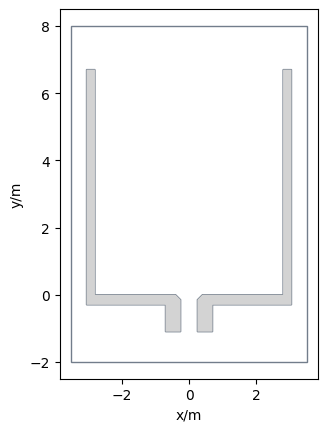

In [2]:
import matplotlib.pyplot as plt
from pedpy import WalkableArea, plot_walkable_area

plot_walkable_area(walkable_area=WalkableArea(geometry)).set_aspect("equal")
plt.show()

In this geometric setup, we now need to define, where the agents can exit the simulation, e.g., where their target is located.

For this scenario, the exit is at the end of the bottleneck.
If we would put it at the beginning of the bottleneck, the agents would disappear, hence, they wouldn't be an obstacle for following agents.

An exit can be defined as:

In [3]:
exit_polygon = shapely.Polygon(
    [(-0.2, -1.9), (0.2, -1.9), (0.2, -1.7), (-0.2, -1.7)]
)

The complete setup would then look like, where the exit is shown in red:

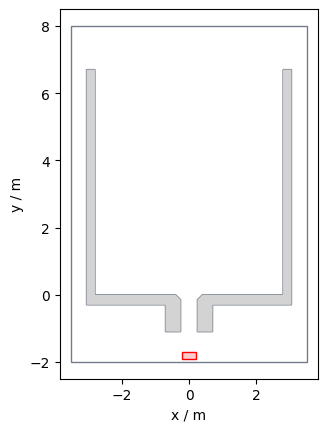

In [4]:
import matplotlib.pyplot as plt
from pedpy import MeasurementArea, WalkableArea, plot_measurement_setup

# We will use PedPy's plotting functionality, but it has no concept of exits
# hence we will show the exit as measurement area
plot_measurement_setup(
    walkable_area=WalkableArea(geometry),
    measurement_areas=[MeasurementArea(exit_polygon)],
    ma_color="r",
    ma_line_color="r",
).set_aspect("equal")
plt.show()

## Distribute the agents in the geometry


The next step is to provide the initial positions of the agents in the simulation. 
*JuPedSim* provides different helper functions to automatically distribute the agents:

- distribute a given number of agents inside a polygon (see {func}`~jupedsim.distribute_by_number`)
- distribute agents by a given density inside a polygon (see {func}`~jupedsim.distribute_by_density`)
- ... (more methods can be found in the [API reference](/api/jupedsim/index), the names start with `distribute`)

However, as we want to compare our simulation to the real-life experimental data, the agents in the simulation will start at the same positions as the pedestrians in the experiment. 
So we load the trajectory from the experiment and extract the locations at frame 0, which is the start of the experiment.

In [5]:
import pandas

experiment_data = pandas.read_csv(
    "demo-data/bottleneck/040_c_56_h-.txt",
    comment="#",
    sep="\t",
    header=None,
    names=["id", "frame", "x", "y", "z"],
)
start_positions = experiment_data[experiment_data.frame == 0][["x", "y"]].values

FileNotFoundError: [Errno 2] No such file or directory: 'demo-data/bottleneck/040_c_56_h-.txt'

## Collision-free speed model

At first, we want to run the simulation with the Collision-free speed model.
In ["Collision-free speed model for pedestrian dynamics"](https://arxiv.org/abs/1512.05597) you can find the complete description of the model.
To use it in *JuPedSim* we need to state, that we will use this model in the creation of the simulation object.

We also need to provide the previously defined geometry and the output file, where the resulting trajectories will be stored. 
Here, we will use the built-in {class}`~jupedsim.SqliteTrajectoryWriter`, which will write the results as a `sqlite`-database.

In [ ]:
import pathlib
import jupedsim as jps

trajectory_file = "bottleneck_cfsm.sqlite"
simulation_cfsm = jps.Simulation(
    model=jps.CollisionFreeSpeedModel(),
    geometry=geometry,
    trajectory_writer=jps.SqliteTrajectoryWriter(
        output_file=pathlib.Path(trajectory_file)
    ),
)



After we defined the simulation we need to add a goal, which the agents should target. 
As we already defined the exit polygon above, we can add it to the simulation as a stage.
After adding the exit to the simulation, we need to create a journey containing that exit.
Journeys are used to manage more complex routing situation, an explanation of the underlying routing concept can be found [here](/concepts/routing).

In [ ]:
exit_id = simulation_cfsm.add_exit_stage(exit_polygon)
journey = jps.JourneyDescription([exit_id])
journey_id = simulation_cfsm.add_journey(journey)

Now we have the setup for the simulation.
But there are no agents in simulation yet, so we need to add them.

Before adding a simulation we need to define the agent specific parameters. 
In this example, all the agents will get the same parameters.
We will now re-use the above extracted start positions of the agents.

In [ ]:
for position in start_positions:
    simulation_cfsm.add_agent(
        jps.CollisionFreeSpeedModelAgentParameters(
            journey_id=journey_id,
            stage_id=exit_id,
            position=position,
            radius=0.12,
        )
    )

After, we have added the agents. 
We've got everything needed to start a simulation.
Here, we will iterate, as long as there are agents inside the simulation, e.g., some agents have not yet reached the exit.

In [ ]:
while (
    simulation_cfsm.agent_count() > 0
    and simulation_cfsm.iteration_count() < 2000
):
    simulation_cfsm.iterate()

Now, every agent has left the simulation.
Let's have a look at the result:

In [ ]:
import pedpy
from jupedsim.internal.notebook_utils import animate, read_sqlite_file

trajectory_data, walkable_area = read_sqlite_file(trajectory_file)
speed = pedpy.compute_individual_speed(traj_data=trajectory_data, frame_step=5)
speed = speed.merge(trajectory_data.data, on=["id", "frame"], how="left")

animate(trajectory_data, walkable_area)

We have set up a first simple simulation with *JuPedSim*.
The results are saved in trajectory files, which can be used for further analyzes. 


For more examples, how to set up simulations have a look at the following notebooks:

- [Movement around corners](corner)
- [Movement through bottlenecks](double-bottleneck)
- [How to work with Journeys](journey)
- [Lane formation in bi-directional flow](lane-formation)
- [Modelling Motivation](motivation)
- [Waiting in Queues](queues_waiting)
- [How Route Choice can Impact Evacuation Times](routing)
- [Simulating Single-File Movement](single-file)

We would love to hear some [feedback](https://www.github.com/PedestrianDynamics/jupedsim/discussions) from you!

## Comparison

After simulating a bottleneck scenario with the initial positions as in the experimental setup, we now want to compare the simulation results with the experiment results.
The first step here, is to have a look at the trajectories of both:

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pedpy

experimental_trajectories = pedpy.load_trajectory(
    trajectory_file=pathlib.Path("demo-data/bottleneck/040_c_56_h-.txt")
)

cfsm_data, walkable_area = read_sqlite_file(trajectory_file)

fig = plt.figure()

ax1 = fig.add_subplot(121, aspect="equal")
ax1.set_title("experimental data")
pedpy.plot_trajectories(
    traj=experimental_trajectories,
    axes=ax1,
    walkable_area=pedpy.WalkableArea(geometry),
)

ax2 = fig.add_subplot(122, aspect="equal")
ax2.set_title("Collision free speed model")
pedpy.plot_trajectories(
    traj=cfsm_data, axes=ax2, walkable_area=pedpy.WalkableArea(geometry)
)
plt.show()

But we do not only want to have a qualitative comparision, but also a quantitive one.
We will use [PedPy](https://pedpy.readthedocs.io) for this analysis, it is a Python library designed for analysing pedestrian movement data.


So, we want to compare the flow of the data sets at the bottleneck.
First, we create a measurement line at the beginning of the bottleneck:

In [ ]:
import pedpy

measurement_line = pedpy.MeasurementLine([(0.35, 0), (-0.35, 0)])

In [ ]:
import pedpy

pedpy.plot_measurement_setup(
    walkable_area=walkable_area,
    measurement_lines=[measurement_line],
    ml_color="red",
    ml_width=2,
).set_aspect("equal")
plt.show()

For this line we can then compute the flow:

In [ ]:
import pedpy

nt_experiment, _ = pedpy.compute_n_t(
    traj_data=experimental_trajectories,
    measurement_line=measurement_line,
)

nt_cfsm, _ = pedpy.compute_n_t(
    traj_data=cfsm_data,
    measurement_line=measurement_line,
)

The results can be seen here:

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("N-t")
ax.plot(
    nt_experiment["time"],
    nt_experiment["cumulative_pedestrians"],
    label="experiment",
)
ax.plot(nt_cfsm["time"], nt_cfsm["cumulative_pedestrians"], label="cfsm")
ax.legend()
ax.set_xlabel("t / s")
ax.set_ylabel("# pedestrians")
plt.show()